In [1]:
# --- Step 1: Mount Google Drive & unzip dataset ---
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/Oil_Spill_Project/dataset.zip" -d /content/oil_spill_data
!ls /content/oil_spill_data

Mounted at /content/drive
dataset  label_colors.txt  test  train	val


In [2]:
# --- Step 2: Import Libraries ---
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
from glob import glob
import random

In [3]:
# --- Step 3: Define dataset paths ---
base_dir = "/content/oil_spill_data"
train_img_dir = os.path.join(base_dir, "train/images")
train_mask_dir = os.path.join(base_dir, "train/masks")
val_img_dir = os.path.join(base_dir, "val/images")
val_mask_dir = os.path.join(base_dir, "val/masks")
test_img_dir = os.path.join(base_dir, "test/images")
test_mask_dir = os.path.join(base_dir, "test/masks")

IMG_SIZE = (256, 256)

In [4]:
# --- Step 4: Load Data Function ---
def load_data(img_dir, mask_dir, img_size=IMG_SIZE, limit=None):
    images, masks = [], []
    file_list = os.listdir(img_dir)
    if limit:
        file_list = file_list[:limit]

    for fname in file_list:
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname.replace(".jpg",".png"))

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is not None and mask is not None:
            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

            img = img / 255.0
            mask = (mask > 127).astype(np.uint8)  # binary mask

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)


In [5]:
# --- Step 5: Load train & val data ---
X_train, y_train = load_data(train_img_dir, train_mask_dir, limit=200)
X_val, y_val = load_data(val_img_dir, val_mask_dir, limit=50)

# Add channel dimension to masks
if y_train.ndim == 3:
    y_train = np.expand_dims(y_train, -1)
if y_val.ndim == 3:
    y_val = np.expand_dims(y_val, -1)

print("Train images:", X_train.shape, "Train masks:", y_train.shape)
print("Val images:", X_val.shape, "Val masks:", y_val.shape)


Train images: (200, 256, 256, 3) Train masks: (200, 256, 256, 1)
Val images: (50, 256, 256, 3) Val masks: (50, 256, 256, 1)


In [6]:
# --- Step 6: Define U-Net Model ---
def unet_model(input_size=(256,256,3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    bn = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    bn = layers.Conv2D(128, (3,3), activation='relu', padding='same')(bn)

    # Decoder
    u3 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(bn)
    u3 = layers.concatenate([u3, c3])
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c5)

    u1 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c5)
    u1 = layers.concatenate([u1, c1])
    c6 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c6)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [7]:
# --- Step 7: Define Metrics (fixed with float casting) ---
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [8]:

# --- Step 8: Compile Model ---
model = unet_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[dice_coef, iou_coef, 'accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │      8,224 │ conv2d_9[0][0]  

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# --- Step 9: Callbacks ---
os.makedirs("/content/checkpoints", exist_ok=True)
checkpoint_path = "/content/checkpoints/unet_oilspill_best.h5"
cp = ModelCheckpoint(checkpoint_path, monitor='val_dice_coef', mode='max',
                     save_best_only=True, verbose=1)

rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)


In [12]:
# --- Step 10: Train Model (with float32 inputs) ---
X_train = X_train.astype("float32")
X_val   = X_val.astype("float32")
y_train = y_train.astype("float32")
y_val   = y_val.astype("float32")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=15,
    callbacks=[cp, rlr],
    verbose=1
)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8380 - dice_coef: 0.8073 - iou_coef: 0.6802 - loss: 0.3482
Epoch 1: val_dice_coef improved from 0.79522 to 0.80291, saving model to /content/checkpoints/unet_oilspill_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8383 - dice_coef: 0.8075 - iou_coef: 0.6805 - loss: 0.3481 - val_accuracy: 0.8696 - val_dice_coef: 0.8029 - val_iou_coef: 0.6925 - val_loss: 0.2860 - learning_rate: 1.2500e-04
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8475 - dice_coef: 0.8388 - iou_coef: 0.7251 - loss: 0.3322
Epoch 2: val_dice_coef did not improve from 0.80291
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8473 - dice_coef: 0.8381 - iou_coef: 0.7241 - loss: 0.3326 - val_accuracy: 0.8723 - val_dice_coef: 0.7908 - val_iou_coef: 0.6750 - val_loss: 0.2938 - learning_rate: 1.2500e-04
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8449 - dice_coef: 0.8100 - iou_coef: 0.6851 - loss: 0.3415
Epoch 3: val_dice_coef did not improve from 0.80291
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8450 - dice_coef: 0.8104 - iou_coef: 0.6855 - loss: 0.3415 - val_accuracy: 0.8753 - val_dice_coef: 0.7964 - val_iou_coef: 0.6825 - val

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8497 - dice_coef: 0.8244 - iou_coef: 0.7035 - loss: 0.3224 - val_accuracy: 0.8784 - val_dice_coef: 0.8052 - val_iou_coef: 0.6949 - val_loss: 0.2770 - learning_rate: 1.2500e-04
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8469 - dice_coef: 0.8210 - iou_coef: 0.6980 - loss: 0.3334
Epoch 7: val_dice_coef did not improve from 0.80524
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8468 - dice_coef: 0.8209 - iou_coef: 0.6980 - loss: 0.3337 - val_accuracy: 0.8718 - val_dice_coef: 0.7934 - val_iou_coef: 0.6788 - val_loss: 0.2916 - learning_rate: 1.2500e-04
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8616 - dice_coef: 0.8351 - iou_coef: 0.7186 - loss: 0.3297
Epoch 8: val_dice_coef did not improve from 0.80524
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8614 - dice_coef: 0.8348 - iou_coef: 0.7182 - loss: 0.3297 - val_accuracy: 0.8589 - val_dice_coef: 0.7811 - val_iou_coef: 0.6601 - val

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8496 - dice_coef: 0.8204 - iou_coef: 0.6969 - loss: 0.3405 - val_accuracy: 0.8803 - val_dice_coef: 0.8105 - val_iou_coef: 0.7007 - val_loss: 0.2747 - learning_rate: 1.2500e-04
Epoch 10/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8623 - dice_coef: 0.8321 - iou_coef: 0.7147 - loss: 0.3372
Epoch 10: val_dice_coef did not improve from 0.81048
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8619 - dice_coef: 0.8320 - iou_coef: 0.7146 - loss: 0.3369 - val_accuracy: 0.8750 - val_dice_coef: 0.8082 - val_iou_coef: 0.6984 - val_loss: 0.2753 - learning_rate: 1.2500e-04
Epoch 11/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8462 - dice_coef: 0.8254 - iou_coef: 0.7044 - loss: 0.3214
Epoch 11: val_dice_coef did not improve from 0.81048
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8465 - dice_coef: 0.8257 - iou_coef: 0.7048 - loss: 0.3215 - val_accuracy: 0.8827 - val_dice_coef: 0.8056 - val_iou_coef: 0.6926 -

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8699 - dice_coef: 0.8384 - iou_coef: 0.7232 - loss: 0.2976 - val_accuracy: 0.8933 - val_dice_coef: 0.8201 - val_iou_coef: 0.7120 - val_loss: 0.2585 - learning_rate: 6.2500e-05
Epoch 14/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8738 - dice_coef: 0.8506 - iou_coef: 0.7415 - loss: 0.3105
Epoch 14: val_dice_coef did not improve from 0.82007
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8737 - dice_coef: 0.8503 - iou_coef: 0.7411 - loss: 0.3102 - val_accuracy: 0.8811 - val_dice_coef: 0.8199 - val_iou_coef: 0.7103 - val_loss: 0.2719 - learning_rate: 6.2500e-05
Epoch 15/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8759 - dice_coef: 0.8445 - iou_coef: 0.7331 - loss: 0.2912
Epoch 15: val_dice_coef improved from 0.82007 to 0.82200, saving model to /content/checkpoints/unet_oilspill_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8758 - dice_coef: 0.8445 - iou_coef: 0.7332 - loss: 0.2915 - val_accuracy: 0.8956 - val_dice_coef: 0.8220 - val_iou_coef: 0.7125 - val_loss: 0.2594 - learning_rate: 6.2500e-05


In [ ]:
# --- Step 11: Save Model ---
save_path = "/content/drive/MyDrive/Oil_Spill_Project/unet_oilspill_final.h5"
model.save(save_path)
print("Model saved to:", save_path)

# Save checkpoint
best_ckpt_drive = "/content/drive/MyDrive/Oil_Spill_Project/unet_oilspill_best.h5"
!cp "{checkpoint_path}" "{best_ckpt_drive}"
print("Best checkpoint copied to:", best_ckpt_drive)


Model saved to: /content/drive/MyDrive/Oil_Spill_Project/unet_oilspill_final.h5
Best checkpoint copied to: /content/drive/MyDrive/Oil_Spill_Project/unet_oilspill_best.h5


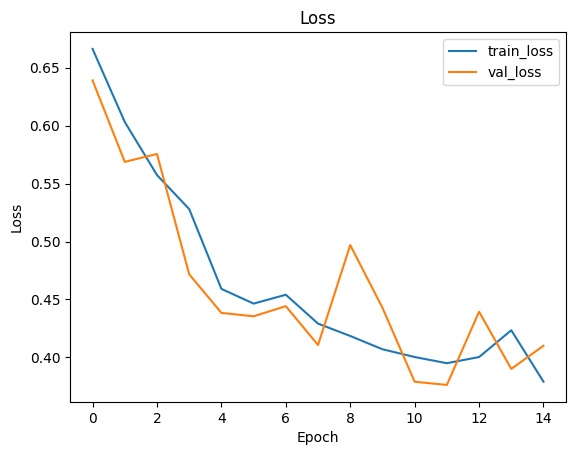

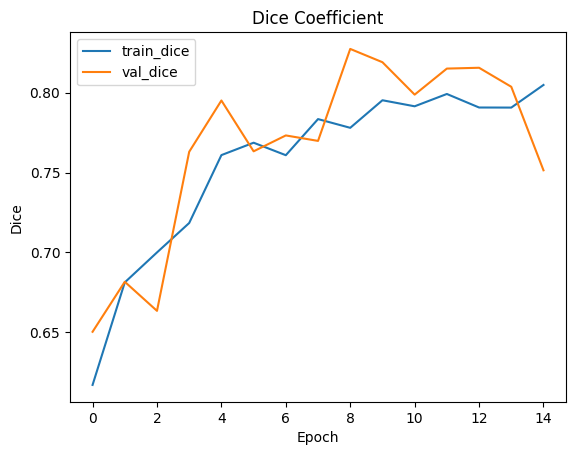

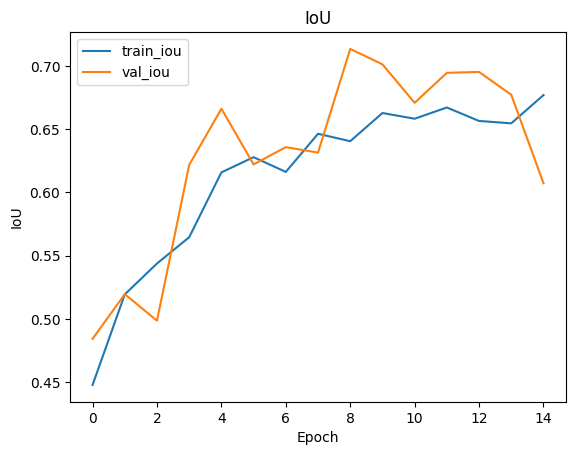

In [ ]:
# --- Step 12: Plot Training Curves ---
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(history.history['dice_coef'], label='train_dice')
plt.plot(history.history['val_dice_coef'], label='val_dice')
plt.legend()
plt.title("Dice Coefficient")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.show()

plt.figure()
plt.plot(history.history['iou_coef'], label='train_iou')
plt.plot(history.history['val_iou_coef'], label='val_iou')
plt.legend()
plt.title("IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.show()


In [ ]:
# --- Step 13: Evaluate on Test Set ---
X_test, y_test = load_data(test_img_dir, test_mask_dir, limit=100)
if y_test.ndim == 3:
    y_test = np.expand_dims(y_test, -1)

X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

print("Test data:", X_test.shape, y_test.shape)

preds = model.predict(X_test, batch_size=8, verbose=1)


Test data: (100, 256, 256, 3) (100, 256, 256, 1)
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 932ms/step


In [ ]:
# --- Step 14: Metrics per image ---
def compute_metrics_per_image(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred >= threshold).astype(np.uint8)
    N = y_true.shape[0]
    ious, dices = [], []
    for i in range(N):
        gt = y_true[i].astype(np.uint8).flatten()
        pr = y_pred_bin[i].astype(np.uint8).flatten()
        inter = np.sum(gt * pr)
        union = np.sum(gt) + np.sum(pr) - inter
        dice = (2 * inter) / (np.sum(gt) + np.sum(pr) + 1e-6) if (np.sum(gt)+np.sum(pr))>0 else 1.0
        iou = inter / (union + 1e-6) if union>0 else 1.0
        dices.append(dice); ious.append(iou)
    return np.mean(dices), np.mean(ious), dices, ious

mean_dice, mean_iou, dices_list, ious_list = compute_metrics_per_image(y_test, preds)
print(f"Test mean Dice: {mean_dice:.4f}, Test mean IoU: {mean_iou:.4f}")


Test mean Dice: 0.7568, Test mean IoU: 0.6673


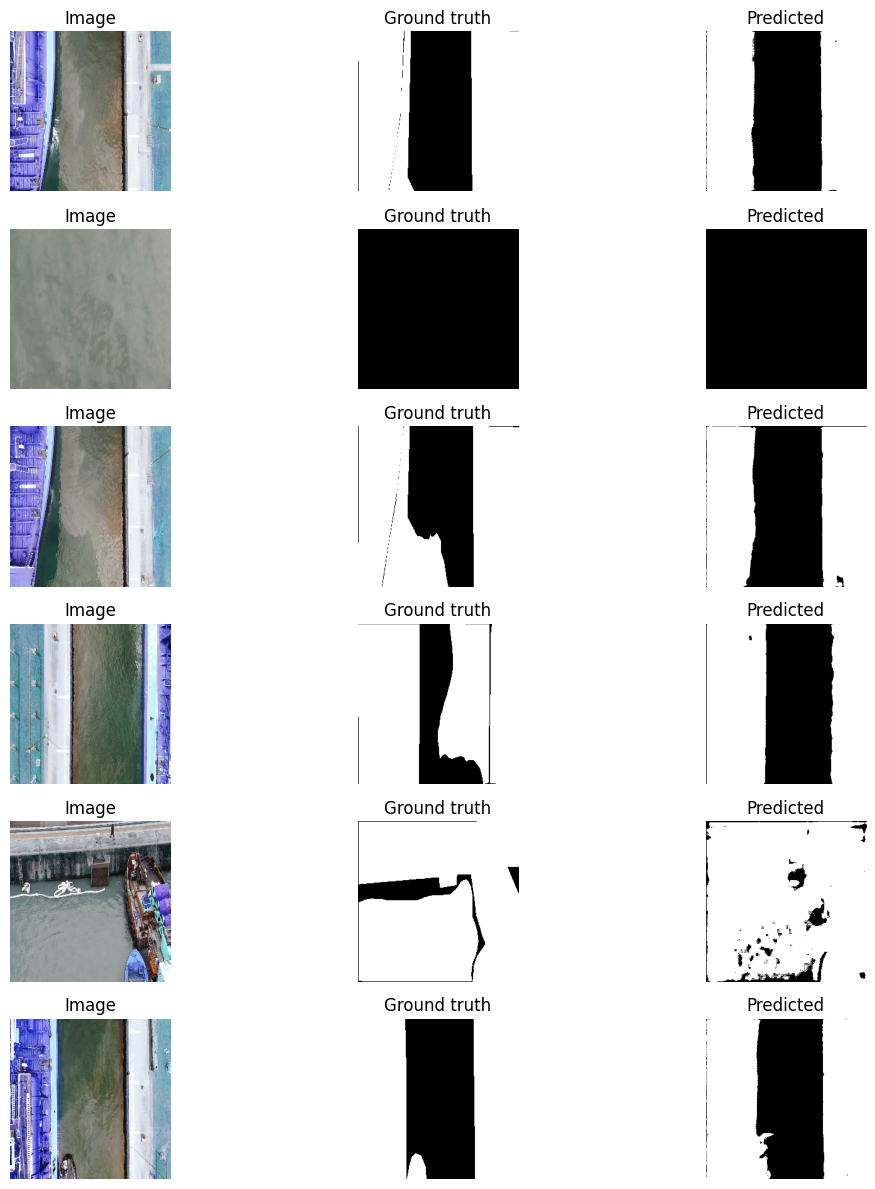

In [ ]:
# --- Step 15: Visualize Predictions ---
n_display = 6
idxs = np.random.choice(len(X_test), size=min(n_display, len(X_test)), replace=False)

plt.figure(figsize=(12, 2*n_display))
for i, idx in enumerate(idxs):
    img = X_test[idx]
    gt = y_test[idx][:,:,0]
    pred = (preds[idx][:,:,0] >= 0.5).astype(np.uint8)

    plt.subplot(n_display, 3, i*3 + 1)
    plt.imshow(img); plt.title("Image"); plt.axis('off')

    plt.subplot(n_display, 3, i*3 + 2)
    plt.imshow(gt, cmap='gray'); plt.title("Ground truth"); plt.axis('off')

    plt.subplot(n_display, 3, i*3 + 3)
    plt.imshow(pred, cmap='gray'); plt.title("Predicted"); plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# --- Step 16: Save Metrics to CSV ---
filenames = [os.path.basename(p) for p in glob(os.path.join(test_img_dir, "*.jpg"))][:len(dices_list)]
df = pd.DataFrame({"filename": filenames, "dice": dices_list, "iou": ious_list})
csv_path = "/content/drive/MyDrive/Oil_Spill_Project/test_metrics.csv"
df.to_csv(csv_path, index=False)
print("Saved test metrics to:", csv_path)

print("✅ Week 3-4 pipeline complete. Model + results saved to Google Drive.")

Saved test metrics to: /content/drive/MyDrive/Oil_Spill_Project/test_metrics.csv
✅ Week 3-4 pipeline complete. Model + results saved to Google Drive.
